In [3]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-08 12:14:37.066567: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 12:14:37.950957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 12:14:37.951005: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 12:14:37.951036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 12:14:38.389378: I tensorflow/core/platform/cpu_feature_g

In [4]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def create_vqa_prompt(coordinates, task, width, height):
    prompt_start = "You are an expert in deciding which coordinates are the most relevant ones for this specific task: "
    prompt_middle = f". There are {len(coordinates)} different coordinates from which you have to choose the most relevant one to succeed in the task. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are: "
    prompt_end = " Output only the coordinates that you decide on in the form of (x, y) with x and y beeing the coordinates. Do not output anything else!"
    return prompt_start + task + prompt_middle + str(coordinates) + prompt_end

def do_vqa(coordinates, task, image_path, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, width, height)
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text
    

Output for task: pick up vegetable and put it on the table.
with coordinates : [(280, 270), (450, 350), (200, 215)]:
 (280, 270)


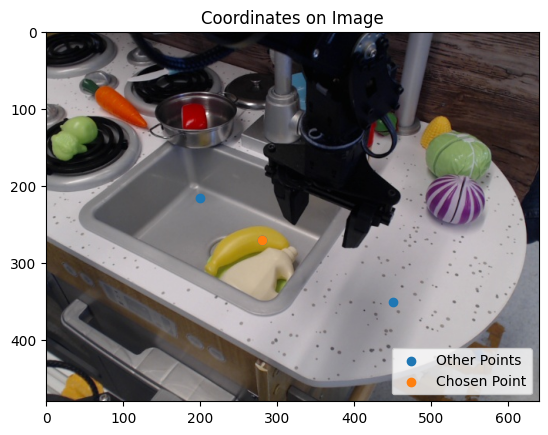

Output for task: pick up the can and put it next to the tomato.
with coordinates : [(130, 250), (500, 300), (300, 350)]:
 (500, 300)


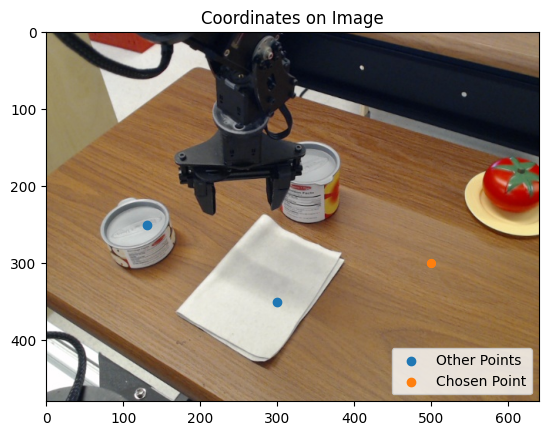

In [30]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    if ("task8" in image_path):
        coordinates = [(130, 250), (500, 300), (300, 350)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    else:
        continue
    

In [58]:
import string
import torch
import matplotlib.pyplot as plt

def create_vqa_prompt(coordinates, task, width, height):
    choices = list(string.ascii_lowercase)
    prompt_coordinates = ""
    for i in range(len(coordinates)):
        prompt_coordinates += f"{choices[i]}: {coordinates[i]}, "

    
    prompt_start = "You are shown a robotic setting. Your mission it to guide and support the robot in its task to: "
    prompt_middle = f". Select the best answer of a multiple choice question with {len(coordinates)} answers to pick up the object that should be moved. The width of the image is {width} pixels and the height of the image is {height} pixels. The multiple choice answers from which you have to choose are the following: "
    
    prompt_end = " Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!"
    return prompt_start + task + prompt_middle + prompt_coordinates + prompt_end

def get_top_probability_distribution(output_char, output_tokens, tokenizer, top_k=10):
    softmax_fn = torch.nn.Softmax(dim=-1)

    logits = output.logits
    generated_logits = torch.cat(logits, dim=0)
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    
    answer_token = generated_tokens[0]
    answer_logits = generated_logits[0]
    
    probs = softmax_fn(answer_logits.squeeze(0))
    
    token_prob = probs[answer_token].item()
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_tokens = [(tokenizer.decode([idx]), top_probs[i].item()) for i, idx in enumerate(top_indices)]

    return token_prob, top_tokens

def do_vqa(coordinates, task, image_path, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, width, height)
        print(f"Prompt: {prompt}")
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text, output, inputs

def visualize_vqa(image, top_tokens, coordinates, title="VQA"):
    tokens, probs = zip(*top_tokens[:len(coordinates)])
    sorted_coordinates = sort_coordinates_by_letters(tokens, coordinates)

    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for prob, token, coordinate in zip(probs, tokens, sorted_coordinates):
        # Extract and plot the points
        x_coords = [x for x, y in [coordinate]]
        y_coords = [y for x, y in [coordinate]]
        label = f"{prob:.4f} ({token})"
        plt.scatter(x_coords, y_coords, marker='o', label=label)
    
    # Add labels and show the plot
    plt.title(title)
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

def sort_coordinates_by_letters(letters, coordinates):
    """
    Sorts the list of coordinates based on the order of the permuted letter list.
    
    :param letters: List of unique lowercase letters (permutation of 'a' to some letter).
    :param coordinates: List of coordinates corresponding to the letters.
    :return: Sorted list of coordinates based on the sorted order of letters.
    """
    letters = [letter.strip() for letter in letters]
    
    expected_letters = [chr(i) for i in range(ord('a'), ord('a') + len(coordinates))]
    if sorted(letters) != expected_letters:
        raise ValueError(f"The letters list must contain a contiguous sequence from 'a' to '{expected_letters[-1]}'")
        
    letter_to_index = {letter: i for i, letter in enumerate(expected_letters)}
    sorted_coordinates = [coordinates[letter_to_index[letter]] for letter in letters]
    return sorted_coordinates

Task: pick up vegetable and put it on the table.
 c: 0.4695
 a: 0.2877
 b: 0.1939
 d: 0.0284
 A: 0.0046


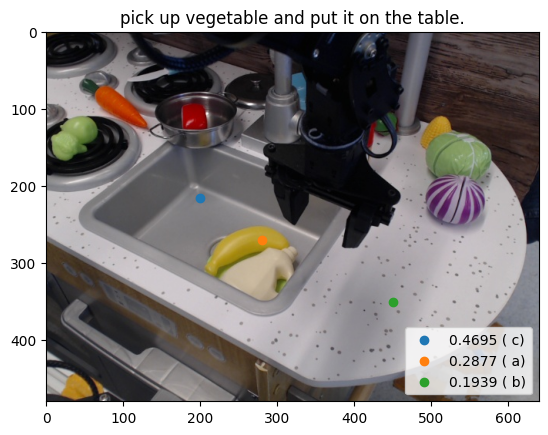

Task: pick up glass cup
 c: 0.3324
 d: 0.2630
 b: 0.2046
 a: 0.1816
 C: 0.0025


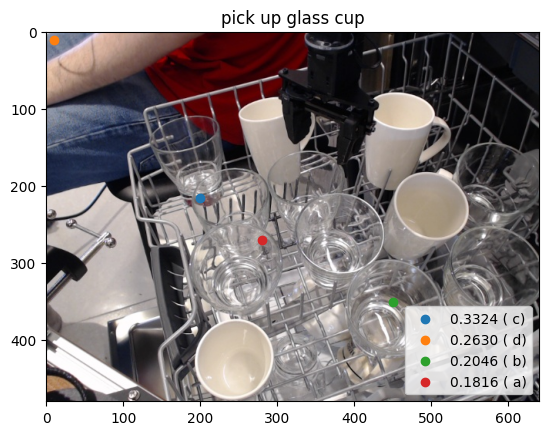

Task: pick up the can and put it next to the tomato.
 c: 0.3765
 a: 0.2618
 d: 0.2205
 b: 0.1232
 C: 0.0032


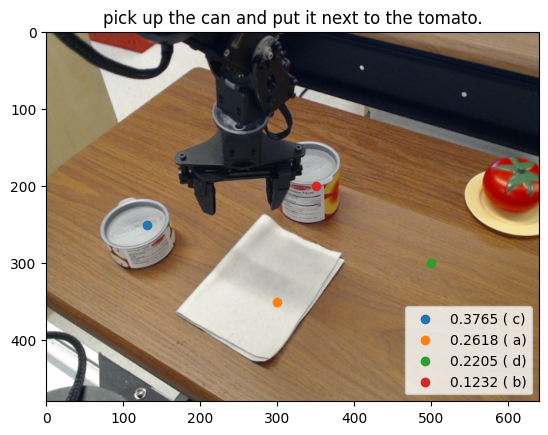

In [51]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task10" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (10, 10)]
    elif("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
    elif("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    else:
        continue

    
    print(f"Task: {task}")
    
    output_text, output, inputs = do_vqa(coordinates, task, image_path, 0.2)
    
    token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer)
    for token, prob in top_tokens:
        print(f"{token}: {prob:.4f}")
    
    with Image.open(image_path) as image:
        visualize_vqa(image, top_tokens, coordinates, title=task)
    

None
Prompt: You are shown a robotic setting. Your mission it to guide and support the robot in its task to: pick up the can. Select the best answer of a multiple choice question with 4 answers to pick up the object that should be moved. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (130, 250), b: (300, 350), c: (500, 300), d: (350, 200),  Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!
 d: 0.3925
 c: 0.3397
 b: 0.1424
 a: 0.1153
 C: 0.0015


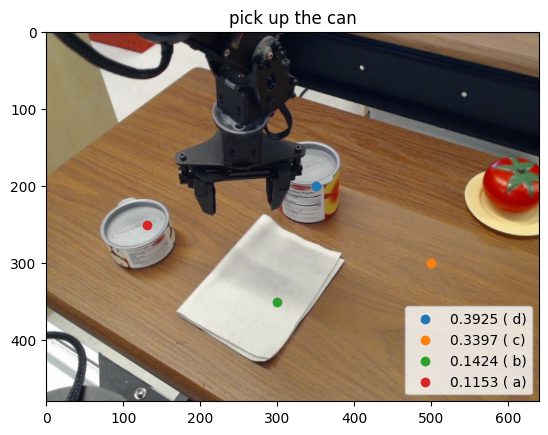

None
Prompt: You are shown a robotic setting. Your mission it to guide and support the robot in its task to: pick up the can. Select the best answer of a multiple choice question with 4 answers to pick up the object that should be moved. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (130, 250), b: (300, 350), c: (350, 200), d: (500, 300),  Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!
 c: 0.4360
 a: 0.1984
 b: 0.1871
 d: 0.1670
 C: 0.0020


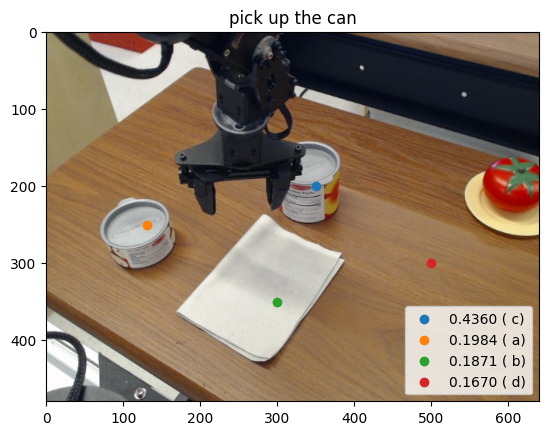

None
Prompt: You are shown a robotic setting. Your mission it to guide and support the robot in its task to: pick up the can. Select the best answer of a multiple choice question with 4 answers to pick up the object that should be moved. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (300, 350), b: (350, 200), c: (130, 250), d: (500, 300),  Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!
 c: 0.3852
 a: 0.2745
 d: 0.1751
 b: 0.1510
 C: 0.0022


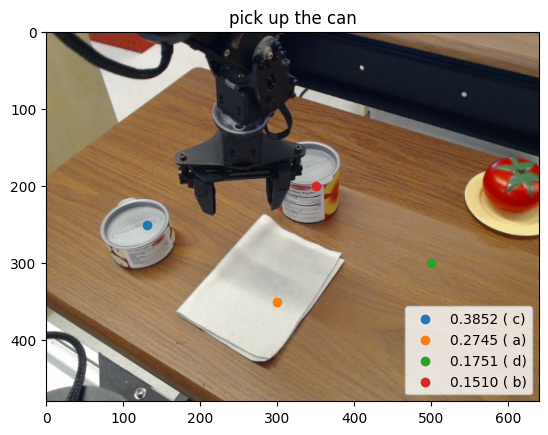

None
Prompt: You are shown a robotic setting. Your mission it to guide and support the robot in its task to: pick up the can. Select the best answer of a multiple choice question with 4 answers to pick up the object that should be moved. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (350, 200), b: (300, 350), c: (130, 250), d: (500, 300),  Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!
 c: 0.6118
 b: 0.1476
 d: 0.1387
 a: 0.0881
 C: 0.0026


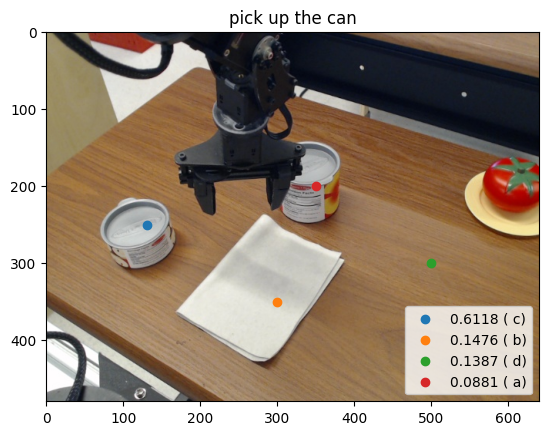

None
Prompt: You are shown a robotic setting. Your mission it to guide and support the robot in its task to: pick up the can. Select the best answer of a multiple choice question with 4 answers to pick up the object that should be moved. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (500, 300), b: (300, 350), c: (130, 250), d: (350, 200),  Your output format should be only the letter of the answer for the coordinate that suits your task best. Do not use whitespace before or after the letter. Do not output anything else!
 c: 0.5154
 d: 0.2444
 b: 0.1660
 a: 0.0635
 C: 0.0021


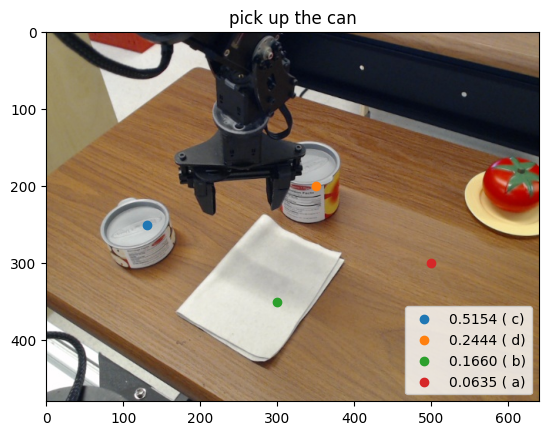

In [65]:
import random
tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    else:
        continue

    for i in range(5):
        shuffled = random.shuffle(coordinates)
        print(shuffled)
        
        output_text, output, inputs = do_vqa(coordinates, task, image_path, 0.2)
        
        token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer, 5)
        for token, prob in top_tokens:
            print(f"{token}: {prob:.4f}")
        
        with Image.open(image_path) as image:
            visualize_vqa(image, top_tokens, coordinates, title=task)